# Exploratory Data Analysis (EDA) – UNSW-NB15 Dataset

This notebook provides an initial exploration of the UNSW-NB15 dataset to understand its structure, data quality, and key statistical patterns. The goal is to gather insights that will inform preprocessing and model design in later stages.

## Dataset Overview

The dataset consists of network flow records labeled as either **normal** or **malicious**. Each row represents a single flow and includes metadata such as source/destination IP, packet size, duration, protocol, and a label column (`label`) indicating whether the flow is part of an attack (1) or normal traffic (0).

We begin by checking the structure and sample data.

In [2]:
# Load the training dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('../data/raw/UNSW_NB15_training-set.csv')

# Show shape and preview
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


## Missing Values

We check whether the dataset contains missing or null values. This helps identify whether imputation or filtering is needed during preprocessing.

In [3]:
# Check for missing values
missing = df.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

## Class Distribution

The `label` column is used as the main classification target. Here we inspect the balance between normal traffic (0) and attack traffic (1). A strong imbalance can affect model performance and may require data balancing techniques such as oversampling or weighting.

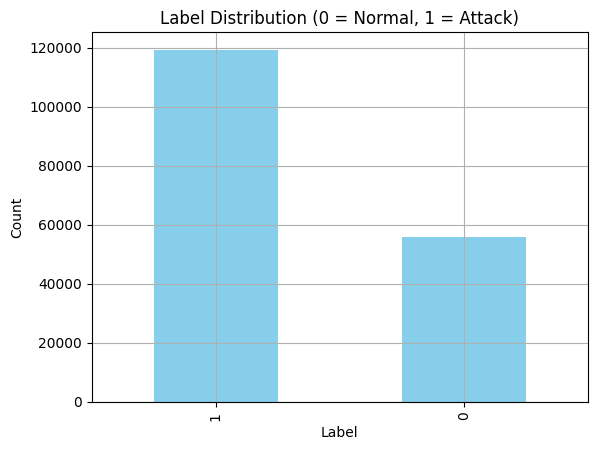

In [4]:
# Label distribution (0 = normal, 1 = attack)
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Label Distribution (0 = Normal, 1 = Attack)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## Attack Category Breakdown

Besides binary labels, the dataset includes an `attack_cat` column with more specific labels (e.g., Exploits, Fuzzers, DoS). This breakdown helps us understand the diversity and imbalance of attack types.

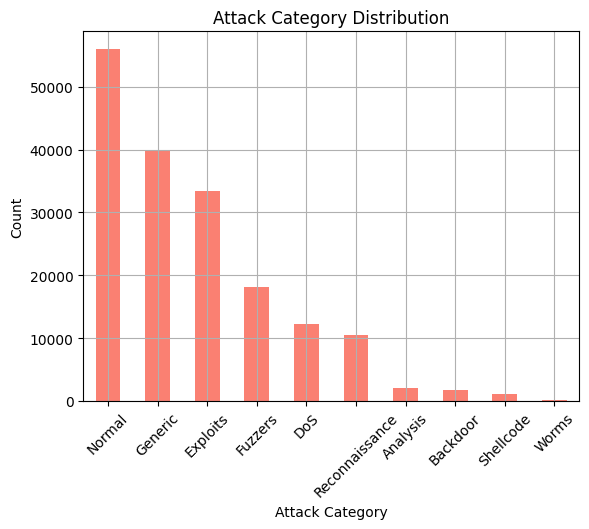

In [5]:
df['attack_cat'].value_counts().plot(kind='bar', color='salmon')
plt.title("Attack Category Distribution")
plt.xlabel("Attack Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Feature Distribution (Boxplots)

To better visualize skewed feature distributions, we use **boxplots** to compare how feature values differ between normal (label = 0) and attack traffic (label = 1).

This makes it easier to identify features that clearly separate the two classes.

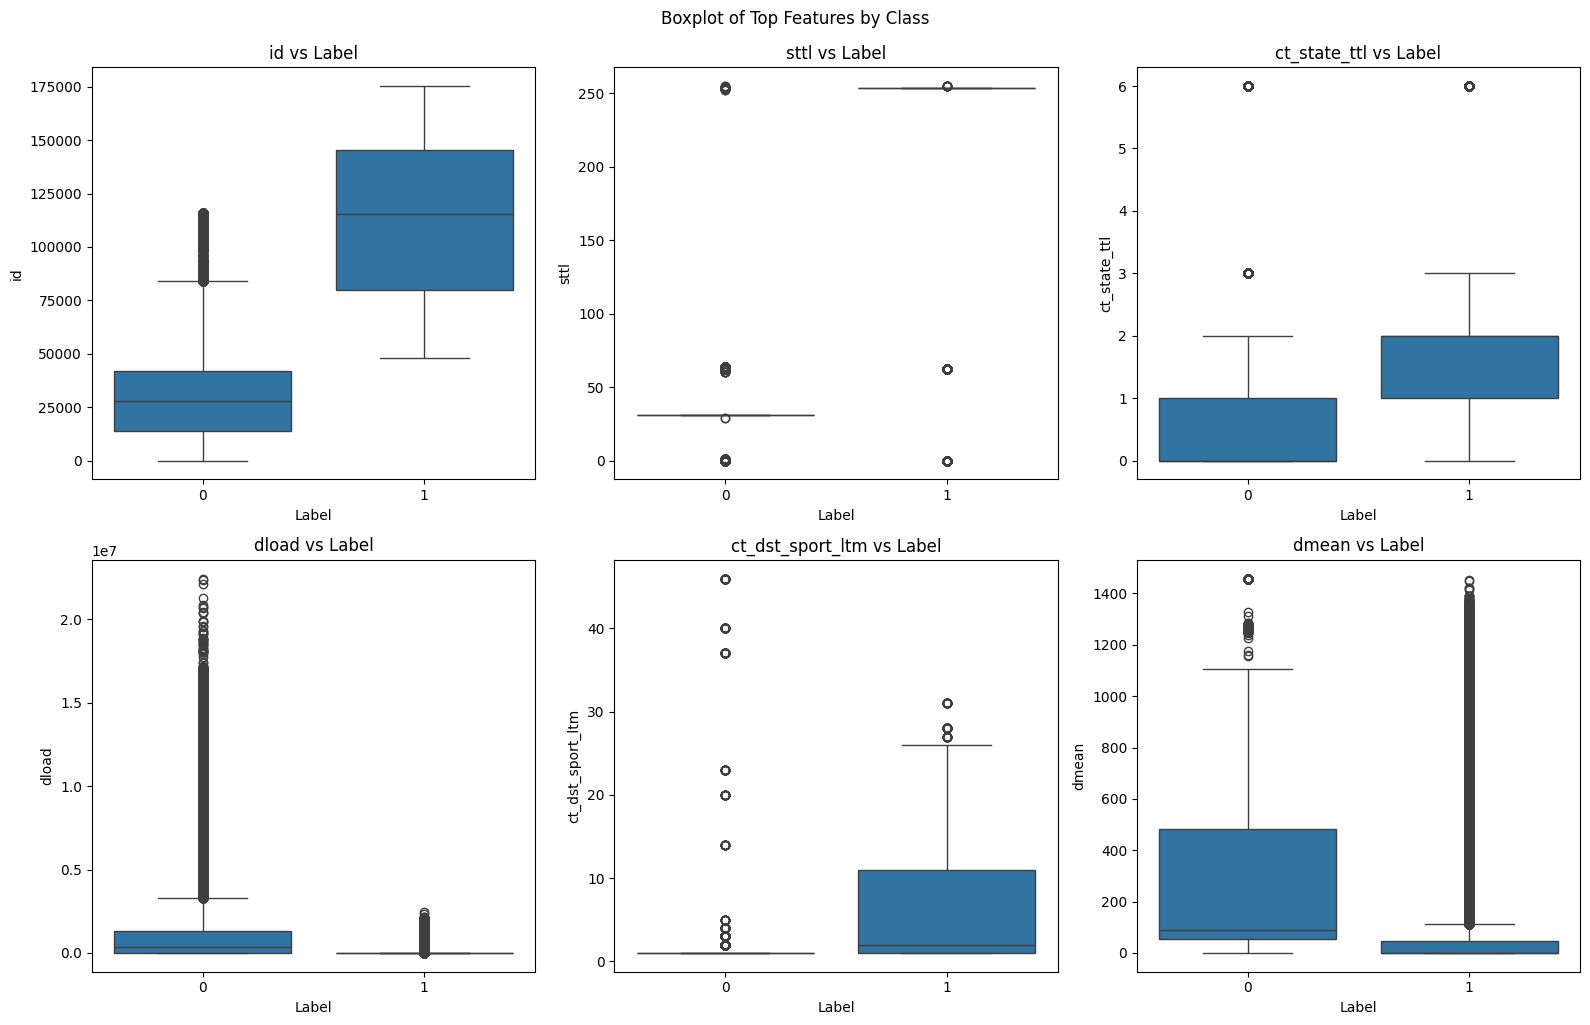

In [7]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlations = df[numeric_cols].corrwith(df['label']).abs().sort_values(ascending=False)

top_features = correlations.drop('label').head(6).index.tolist()

plt.figure(figsize=(16, 10))

for i, col in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f'{col} vs Label')
    plt.xlabel('Label')
    plt.tight_layout()

plt.suptitle("Boxplot of Top Features by Class", y=1.02)
plt.show()


## 🔗 Correlation with Labels

We identify the top 10 features most strongly correlated with the binary label. These features are likely to be important predictors for our deep learning models.

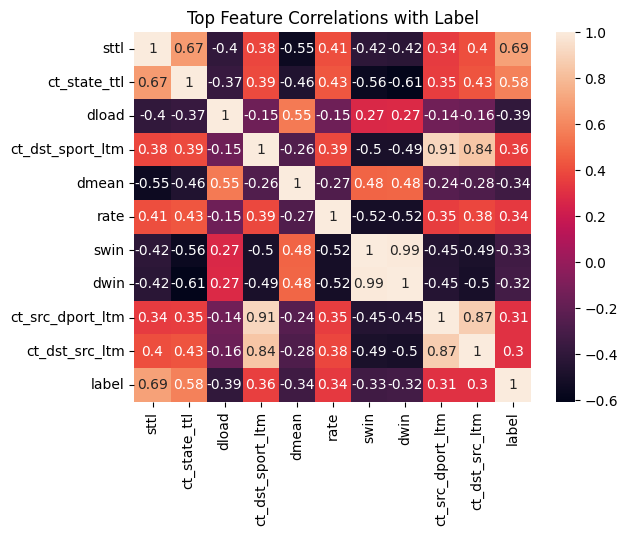

In [10]:
# Recreate numeric subset (excluding label)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
subset = df[numeric_cols].drop(columns=['label', 'id'], errors='ignore')

# Correlation of features with label
corr = subset.corrwith(df['label']).abs().sort_values(ascending=False)[:10]
top_features = corr.index.tolist()

sns.heatmap(df[top_features + ['label']].corr(), annot=True)
plt.title("Top Feature Correlations with Label")
plt.show()


## EDA Summary & Insights

Based on the correlation heatmap and boxplot analysis, we can conclude the following key observations from the UNSW-NB15 dataset:

### Important features:
- sttl – Strong correlation (0.69) and clear class separation
- ct_state_ttl – High correlation (0.58) and low variance in attack traffic
- ct_dst_sport_ltm – Captures connection behavior; high values common in attacks
- dmean – Lower mean byte size in attacks
- dload – Normal traffic shows much higher and more variable data loads
- rate - reflects packet speed in a flow. Attacks often have lower, consistent rates—typical of automated behavior. Not highly predictive alone, but adds useful behavioral context.

### Redundant or less useful:
- ct_dst_src_ltm & ct_src_dport_ltm – Strong correlation with each other (*not identique) → pick one to avoid multicollinearity
- id – Likely a row index or ordering column; not informative
-  `swin` (source window) and `dwin` (destination window) show highly similar distributions and are strongly correlated with each other. Keeping both may introduce multicollinearity with minimal predictive gain. Drop both to simplify the feature set.